<a href="https://colab.research.google.com/github/JaeDoo1034/DACON_EMNIST/blob/master/keras%2Ctensorflow%EB%A1%9C_%EA%B5%AC%ED%98%84%ED%95%9C_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Keras 와 Tensorflow로 구현한 CNN

- CNN을 통해 글자에 가려진(노이즈가 있는) 숫자를 예측하기 위한 모델을 설계해 보았다.\
  (MNIST 데이터위에 필기체인 글씨가 겹쳐져 있는 데이터)

- train.csv : 훈련 데이터 2048개
- test.csv : 검증 데이터 20480개

In [ ]:
!pip install -q tensorflow-gpu==2.0.0-rc1

     |████████████████████████████████| 380.5MB 44kB/s 
     |████████████████████████████████| 501kB 55.6MB/s 
     |████████████████████████████████| 4.3MB 52.0MB/s 
     |████████████████████████████████| 51kB 8.7MB/s 


In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib
from matplotlib import font_manager, rc
import platform


try : 
    if platform.system() == 'Windows':
    # 윈도우인 경우
        font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
        rc('font', family=font_name)
    else:    
    # Mac 인 경우
        rc('font', family='AppleGothic')
except : 
    pass
matplotlib.rcParams['axes.unicode_minus'] = False   

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


#### 데이터 불러오기

In [ ]:
import io

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving test.csv to test.csv
Saving train.csv to train.csv


In [ ]:
train = pd.read_csv(io.BytesIO(uploaded['train.csv']))
train.head()

,id,digit,letter,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,...,744,745,746,747,748,749,750,751,752,753,754,755,756,757,758,759,760,761,762,763,764,765,766,767,768,769,770,771,772,773,774,775,776,777,778,779,780,781,782,783
0,1,5,L,1,1,1,4,3,0,0,4,4,3,0,4,3,3,3,4,4,0,0,1,1,3,4,0,4,2,0,4,0,1,3,1,0,4,1,1,3,...,4,3,4,1,3,0,0,1,3,3,3,0,3,2,2,1,0,1,0,0,3,0,0,4,2,0,3,4,1,1,2,1,0,1,2,4,4,4,3,4
1,2,0,B,0,4,0,0,4,1,1,1,4,2,0,3,4,0,0,2,3,4,0,3,4,3,0,2,2,1,4,2,3,3,4,1,2,4,2,0,3,...,4,2,3,0,0,0,0,4,3,2,2,4,2,1,1,1,3,3,1,2,4,4,4,2,2,4,4,0,4,2,0,3,0,1,4,1,4,2,1,2
2,3,4,L,1,1,2,2,1,1,1,0,2,1,3,2,2,2,4,1,1,4,1,0,1,3,4,2,2,2,4,1,1,2,0,3,0,2,3,4,0,...,3,0,4,0,3,0,2,0,1,4,2,3,4,4,4,0,2,0,4,4,1,3,0,3,2,0,2,3,0,2,3,3,3,0,2,0,3,0,2,2
3,4,9,D,1,2,0,2,0,4,0,3,4,3,1,0,3,2,2,0,3,4,1,0,4,1,2,2,3,2,2,0,2,0,3,0,3,2,4,0,0,...,0,3,0,1,4,1,3,1,2,1,1,1,2,2,2,4,3,4,3,0,4,1,2,4,1,4,0,1,0,4,3,3,2,0,1,4,0,0,1,1
4,5,6,A,3,0,2,4,0,3,0,4,2,4,2,1,4,1,1,4,4,0,2,3,4,4,3,3,3,3,4,1,0,3,0,3,0,0,0,1,1,...,2,1,3,2,1,4,2,3,2,2,1,0,4,2,2,1,2,1,0,3,2,2,2,2,1,4,2,1,2,1,4,4,3,2,1,3,4,3,1,2


#### 데이터는 28*28의 2차원 이미지의 형태

In [ ]:
train.digit.value_counts() /train.digit.value_counts().sum()

2    0.113770
5    0.109863
6    0.103516
4    0.101074
3    0.100098
1    0.098633
9    0.096191
7    0.094727
0    0.093262
8    0.088867
Name: digit, dtype: float64

In [ ]:
#28*28 의 형태
train.shape

(2048, 787)

target의 category / 가리고 있는 글자의 category

In [ ]:
#고유값들 뽑아내기
label1=train['letter'].unique()
label2=train['digit'].unique()
print("letter:",np.sort(label1))
print("digit:",np.sort(label2))

letter: ['A' 'B' 'C' 'D' 'E' 'F' 'G' 'H' 'I' 'J' 'K' 'L' 'M' 'N' 'O' 'P' 'Q' 'R'
 'S' 'T' 'U' 'V' 'W' 'X' 'Y' 'Z']
digit: [0 1 2 3 4 5 6 7 8 9]


#### CNN 모델에 이미지를 넣기 위해서는 3차원의 형태로 변환을 해 주어야 한다.
- 여기서 초기 이미지는 28*28의 형태이므로\
  (데이터 수, 28, 28)의 형태로 변환한다.

In [ ]:
#이미지데이터를 28*28의 형태로 변환
image=np.array(train.iloc[:,3:]).reshape(-1,28,28)
image.shape

(2048, 28, 28)

In [ ]:
image

array([[[1, 1, 1, ..., 2, 0, 4],
        [0, 1, 3, ..., 4, 1, 3],
        [2, 0, 4, ..., 3, 3, 3],
        ...,
        [2, 1, 2, ..., 4, 1, 0],
        [3, 3, 3, ..., 3, 3, 0],
        [3, 2, 2, ..., 4, 3, 4]],

       [[0, 4, 0, ..., 1, 4, 2],
        [3, 3, 4, ..., 3, 4, 2],
        [1, 4, 2, ..., 4, 0, 4],
        ...,
        [2, 4, 4, ..., 0, 0, 1],
        [3, 1, 4, ..., 2, 2, 4],
        [2, 1, 1, ..., 2, 1, 2]],

       [[1, 1, 2, ..., 2, 4, 1],
        [1, 2, 0, ..., 2, 4, 0],
        [4, 2, 0, ..., 1, 3, 3],
        ...,
        [3, 0, 1, ..., 2, 2, 1],
        [0, 3, 2, ..., 4, 2, 3],
        [4, 4, 4, ..., 0, 2, 2]],

       ...,

       [[4, 0, 4, ..., 3, 2, 3],
        [4, 3, 1, ..., 4, 4, 4],
        [3, 2, 0, ..., 1, 3, 0],
        ...,
        [4, 0, 4, ..., 0, 2, 0],
        [4, 3, 1, ..., 0, 4, 4],
        [1, 3, 3, ..., 2, 0, 0]],

       [[2, 3, 3, ..., 0, 1, 2],
        [4, 1, 4, ..., 4, 0, 0],
        [3, 1, 3, ..., 3, 3, 3],
        ...,
        [1, 1, 4, ..., 

### 현재 데이터가 어떤 이미지를 구성하고 있는지 알아본다.

findfont: Font family ['AppleGothic'] not found. Falling back to DejaVu Sans.


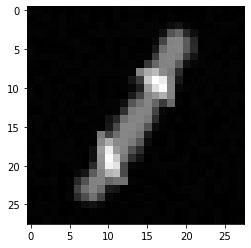

id: 68
letter: L
digit: 0


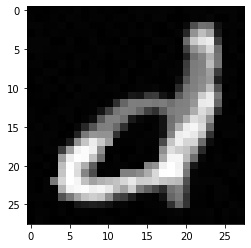

id: 710
letter: D
digit: 2


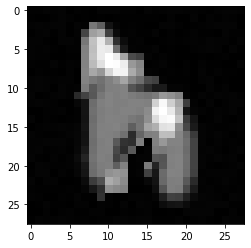

id: 1269
letter: H
digit: 7


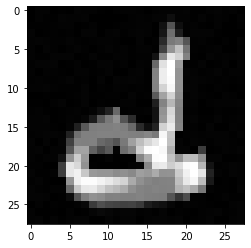

id: 550
letter: D
digit: 2


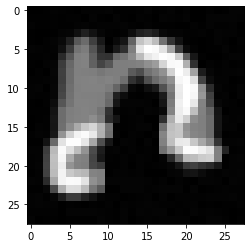

id: 1301
letter: N
digit: 2


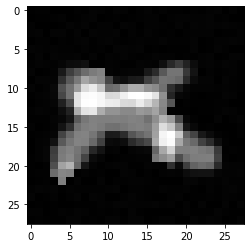

id: 1612
letter: X
digit: 5


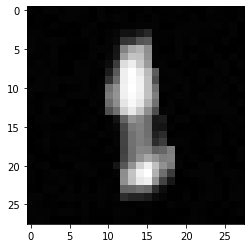

id: 553
letter: L
digit: 5


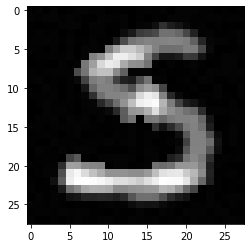

id: 226
letter: S
digit: 2


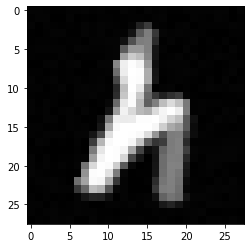

id: 230
letter: H
digit: 2


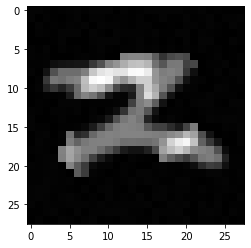

id: 920
letter: Z
digit: 0


In [ ]:
#몇개의 이미지가 어떤 형태인지 살펴 본다. random 하게 
import random

for i in range(10):
    ran=random.randint(0,2048)
    image=np.array(train.iloc[[ran],3:]).reshape(28,28).astype(np.float)
    plt.imshow(image,cmap='gray')
    plt.show()
    print("id:",ran+1)
    print("letter:",train.iloc[ran]['letter'])
    print("digit:",train.iloc[ran]['digit'])

### CNN 사용

In [ ]:
!pip install --upgrade tensorflow

Requirement already up-to-date: tensorflow in /usr/local/lib/python3.6/dist-packages (2.3.0)


In [ ]:
%tensorflow_version 2.3
import tensorflow as tf

`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `2.3`. This will be interpreted as: `2.x`.


TensorFlow 2.x selected.


In [ ]:
from keras.utils.np_utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras import layers
from keras.layers.normalization import BatchNormalization

#### CNN에 들어갈 수 있도록 np.array를 통해 데이터의 차원 변경 

In [ ]:
x_train=np.array(train.iloc[:,3:]).reshape(-1,28,28,1).astype(np.float)
y_train=to_categorical(train['digit'].values)

In [ ]:
x_train.shape

(2048, 28, 28, 1)

In [ ]:
y_train.shape

(2048, 10)

#### train data 와 validation data 를 나누어 모델의 학습에 사용

In [ ]:
#train , val 나누기 (0.2사용)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size = 0.2)

In [ ]:
x_train.shape[0]

1638

In [ ]:
x_val.shape[0]

410

#### 현재 데이터의 수가 적으므로 imagegenerator를 통해 데이터를 증식

In [ ]:
#이미지 데이터 증식 여러각도로 바꾸어 본다. 
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.1,
    fill_mode='nearest'
    )
train_datagen.fit(x_train)
test_datagen=ImageDataGenerator(rescale=1./255)

In [ ]:
x_train.shape

(1638, 28, 28, 1)

In [ ]:
from keras.wrappers.scikit_learn import KerasClassifier

#### 모델의 구성 (keras를 이용)
1) Conv2D 계층과 그 뒤에 Pooling 계층을 연결
 - 초기에는 뒤의 Dense를 2개 두었지만 AlexNet을 모방하여 Dense를 늘리니 정확도가 상승
 
2) 활성화 함수, 옵티마이저의 변경: Leaky Relu 와 nadam,adagrad,msd 등을 사용해 보았지만 adam이 정확도가 좋아보임

3) Drop out 계층의 추가를 통해 정확도 상승 실험(Drop out 비율조정시 0.5가 좋아보임)

4) padding을 적용시켜 데이터의 손실을 막아봄

In [ ]:
model = keras.Sequential()
model.add(layers.Conv2D(64, kernel_size=3, activation='relu',padding='same',
                        input_shape=x_train.shape[1:]))
model.add(layers.Conv2D(64, kernel_size=3,padding='same', activation='relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Dropout(0.4))

model.add(layers.Conv2D(64, kernel_size=3,padding='same', activation='relu'))
model.add(layers.Conv2D(64, kernel_size=3,padding='same', activation='relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Dropout(0.4))

model.add(layers.Conv2D(128, kernel_size=3,padding='same', activation='relu'))
model.add(layers.Conv2D(128, kernel_size=3,padding='same', activation='relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Dropout(0.4))

model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(y_train.shape[1], activation='softmax'))
model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_51 (Conv2D)           (None, 28, 28, 64)        640       
_________________________________________________________________
conv2d_52 (Conv2D)           (None, 28, 28, 64)        36928     
_________________________________________________________________
max_pooling2d_30 (MaxPooling (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_23 (Dropout)         (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_53 (Conv2D)           (None, 14, 14, 64)        36928     
_________________________________________________________________
conv2d_54 (Conv2D)           (None, 14, 14, 64)        36928     
_________________________________________________________________
max_pooling2d_31 (MaxPooling (None, 7, 7, 64)        

In [ ]:
optimizer = keras.optimizers.Adam(lr = 0.001, beta_1 = 0.9, beta_2 = 0.999)

In [ ]:
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

In [ ]:
batch=32
epoch=300

#### 모델의 학습과 Overfitting 방지 
- Early stopping과 callback을 통해, 지속적으로 Val_accuracy를 모니터링 하여\
  학습이 진행되어가며 Val_accuracy가 개선되지 않으면(증가되거나 지속) 학습을 종료하고\
  가장 좋은 Val_accuray를 보여주었던 모델의 가중치를 best_model.h5로 저장

In [ ]:
train.digit.value_counts() / train.digit.value_counts().sum()

2    0.113770
5    0.109863
6    0.103516
4    0.101074
3    0.100098
1    0.098633
9    0.096191
7    0.094727
0    0.093262
8    0.088867
Name: digit, dtype: float64

In [ ]:
class_weight = {
    0: 0.093262,
    1: 0.098633,
    2: 0.113770,
    3: 0.100098,
    4: 0.101074,
    5: 0.109863,
    6: 0.103516,
    7: 0.094727,
    8: 0.088867,
    9: 0.096191,
}

In [ ]:
early_stop = [keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=50),
            keras.callbacks.ModelCheckpoint(filepath='C:/workspace/DACON/EMNIST/model/best_model1.h5',monitor='val_accuracy',save_best_only=True)]

history = model.fit_generator(
    train_datagen.flow(x_train, y_train, batch_size=32),
    steps_per_epoch=x_train.shape[0]//batch, # 전체 데이터 수 / 배치 사이즈
    epochs=epoch,
    validation_data=test_datagen.flow(x_val, y_val),
   # class_weight = class_weight,
    verbose=2,
    callbacks=early_stop
)

Epoch 1/300
51/51 - 1s - loss: 0.2141 - accuracy: 0.9309 - val_loss: 0.8537 - val_accuracy: 0.7829
Epoch 2/300
51/51 - 1s - loss: 0.1872 - accuracy: 0.9346 - val_loss: 0.6798 - val_accuracy: 0.8195
Epoch 3/300
51/51 - 1s - loss: 0.1962 - accuracy: 0.9296 - val_loss: 0.6666 - val_accuracy: 0.8220
Epoch 4/300
51/51 - 1s - loss: 0.2417 - accuracy: 0.9197 - val_loss: 0.5993 - val_accuracy: 0.8244
Epoch 5/300
51/51 - 1s - loss: 0.2056 - accuracy: 0.9278 - val_loss: 0.5940 - val_accuracy: 0.8439
Epoch 6/300
51/51 - 1s - loss: 0.1941 - accuracy: 0.9384 - val_loss: 0.7211 - val_accuracy: 0.8098
Epoch 7/300
51/51 - 1s - loss: 0.1919 - accuracy: 0.9340 - val_loss: 0.6445 - val_accuracy: 0.8512
Epoch 8/300
51/51 - 1s - loss: 0.2053 - accuracy: 0.9303 - val_loss: 0.7294 - val_accuracy: 0.8146
Epoch 9/300
51/51 - 1s - loss: 0.2042 - accuracy: 0.9309 - val_loss: 0.7036 - val_accuracy: 0.8146
Epoch 10/300
51/51 - 1s - loss: 0.2182 - accuracy: 0.9253 - val_loss: 0.5946 - val_accuracy: 0.8293
Epoch 11/

#### 모델의 학습과정과 val_accuray의 변화

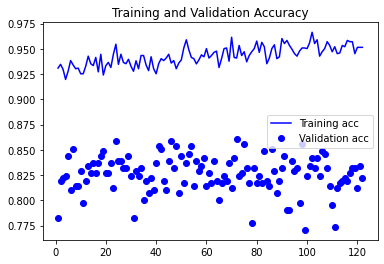

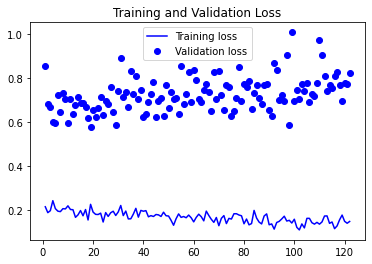

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'bo', label='Validation acc')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.show()

### test데이터를 통한 모델의 정확도 검증
 초기(08.01) : 0.72 (72%) 로 시작\
 마지막(08.15) : 0.86 (86%) 까지 증가

In [ ]:
test= pd.read_csv(io.BytesIO(uploaded['test.csv']))

In [ ]:
bestmodel = keras.models.load_model('best_model1.h5')
bestmodel.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_51 (Conv2D)           (None, 28, 28, 64)        640       
_________________________________________________________________
conv2d_52 (Conv2D)           (None, 28, 28, 64)        36928     
_________________________________________________________________
max_pooling2d_30 (MaxPooling (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_23 (Dropout)         (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_53 (Conv2D)           (None, 14, 14, 64)        36928     
_________________________________________________________________
conv2d_54 (Conv2D)           (None, 14, 14, 64)        36928     
_________________________________________________________________
max_pooling2d_31 (MaxPooling (None, 7, 7, 64)        

In [ ]:
x_test = np.array(test.iloc[:, 2:]).reshape(-1, 28, 28, 1).astype(np.float)
x_test /= 255.
print(x_test.shape)
pred = bestmodel.predict(x_test)
pred = np.argmax(pred, axis=1)
print(pred.shape)

(20480, 28, 28, 1)
(20480,)


In [ ]:
pred

array([6, 8, 8, ..., 6, 3, 0])

In [ ]:
submission=pd.read_csv("C:\\Users\\Chunghun\\Desktop\\data\\submission.csv",index_col=0)

In [ ]:
submission.digit = pred
submission.head()

In [ ]:
submission.to_csv("C:\\Users\\Chunghun\\Desktop\\data\\submission1.csv")

#### 이전 좋은 정확도를 보여줬던 모델들의 형태 기록 및 갱신
- 앙상블을 통한 Voting 이 좋은 정확도를 보여줬었음

In [ ]:
'''
#best model5 = adam #val_accuracy = 0.8098 # batch size=32
model = keras.Sequential()
model.add(layers.Conv2D(32, kernel_size=3,padding='same', activation='relu',
                        input_shape=x_train.shape[1:]))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(64, kernel_size=3,padding='same', activation='relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(128, kernel_size=3,padding='valid', activation='relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Dropout(0.1))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(y_train.shape[1], activation='softmax'))
model.summary()

#best model1= adam 
Epoch 90/300
51/51 - 2s - loss: 0.4684 - accuracy: 0.8275 - val_loss: 0.4848 - val_accuracy: 0.8683
model = keras.Sequential()
model.add(layers.Conv2D(32, kernel_size=3,padding='same', activation='relu',
                        input_shape=x_train.shape[1:]))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(64, kernel_size=3,padding='same', activation='relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(128, kernel_size=3,padding='same', activation='relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Dropout(0.5))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(y_train.shape[1], activation='softmax'))
model.summary()

'''

